<a href="https://colab.research.google.com/github/sebastianbarros1976/sebastianbarros1976/blob/main/Breast_cancer_Detection_CNN_Ultrasound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Gradio
!pip install gradio

# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import gradio as gr

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.6 M

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding=1)
        self.conv4 = nn.Conv2d(48, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*64, 922)
        self.fc2 = nn.Linear(922, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.batchn1 = nn.BatchNorm2d(16)
        self.batchn2 = nn.BatchNorm2d(32)
        self.batchn3 = nn.BatchNorm2d(48)
        self.batchn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool1(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool2(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool2(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool2(F.relu(self.batchn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Instantiate the model and move it to the device
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)


In [ ]:
data_dir = '/content/drive/MyDrive/ultrasound breast classification'
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

# Debug: Check data loader
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(valid_loader))


Number of training batches: 326
Number of validation batches: 82


Streaming output truncated to the last 5000 lines.
Batch 62: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 63: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 64: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 65: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 66: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 67: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 68: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 69: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Processing batch 70/326
Batch 70: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 71: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 72: images.shape = torch.Size([20, 3, 2

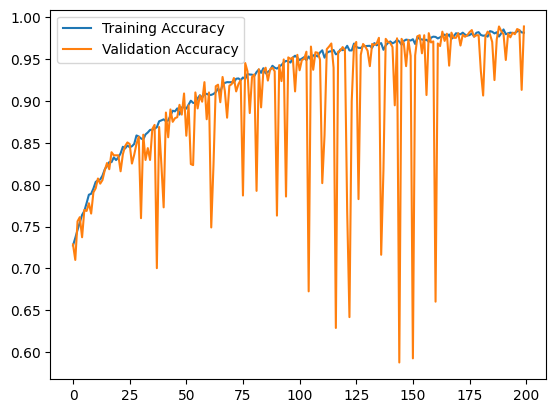

In [ ]:
epochs = 200 # Start with a small number of epochs for testing
valid_loss_min = np.Inf
train_accuracy, val_accuracy = [], []

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    model.train()

    print(f'Starting epoch {epoch+1}/{epochs}...')  # Debug: Start of epoch
    for i, (images, labels) in enumerate(train_loader):
        if i % 10 == 0:
            print(f'Processing batch {i}/{len(train_loader)}')  # Debug: Batch progress

        # Add additional checks to ensure data is loaded correctly
        if images is None or labels is None:
            print(f"Batch {i} contains None values.")
            continue

        print(f"Batch {i}: images.shape = {images.shape}, labels.shape = {labels.shape}")

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item() * images.size(0)
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} training completed.')

    with torch.no_grad():
        model.eval()
        v_acc = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item() * images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_accuracy.append(t_acc / len(train_loader.sampler))
    val_accuracy.append(v_acc / len(valid_loader.sampler))

    print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), "model_cnn.pt")
        valid_loss_min = valid_loss

# Load the best model
model.load_state_dict(torch.load("model_cnn.pt"))

# Plot training and validation accuracy
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
# Load the best model
model.load_state_dict(torch.load("model_cnn.pt"))


<All keys matched successfully>

In [ ]:
def validate_model(model, valid_loader, criterion):
    valid_loss = 0.0
    v_acc = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item() * images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()
    valid_loss = valid_loss / len(valid_loader.sampler)
    v_acc = v_acc / len(valid_loader.sampler)
    return valid_loss, v_acc


In [ ]:
# Validation
valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion)
print(f'Validation Loss: {valid_loss:.6f}, Validation Accuracy: {valid_accuracy:.6f}')

# Define classes
classes = ['benign', 'malignant']

# Test the model
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Validation Loss: 0.047026, Validation Accuracy: 0.988923
Test Loss: 0.281762

Test Accuracy of benign: 88% (442/500)
Test Accuracy of malignant: 96% (387/400)

Test Accuracy (Overall): 92% (829/900)


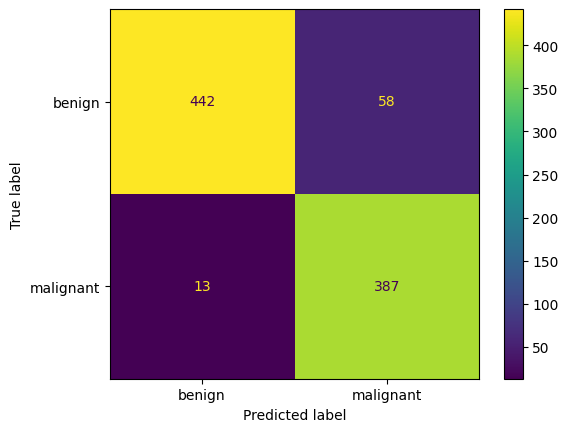

In [ ]:
# Step 2: Evaluation Metrics

target = []
predictions = []
model.eval()
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        logits = model(data)
        logits = (torch.max(torch.exp(logits), 1)[1]).cpu().data.numpy()
        predictions.extend(logits)
        label = label.cpu().data.numpy()
        target.extend(label)
cm = confusion_matrix(target, predictions)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
dis.plot()
plt.show()


In [ ]:
print(classification_report(target, predictions, target_names=classes))


              precision    recall  f1-score   support

      benign       0.97      0.88      0.93       500
   malignant       0.87      0.97      0.92       400

    accuracy                           0.92       900
   macro avg       0.92      0.93      0.92       900
weighted avg       0.93      0.92      0.92       900



In [ ]:
import gradio as gr
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import random

# Load the pre-trained model
model = Classifier()  # Ensure this matches your model definition
model.load_state_dict(torch.load("model_cnn.pt", map_location=torch.device('cpu')))
model.eval()

# Define the classes
classes = ['benign', 'malignant']

# Define the transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def predict(image):
    image = test_transforms(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        class_idx = pred.item()
        accuracy = 92  # example accuracy percentage

        advice = {
            'benign': "The ultrasound image suggests that the tumor is benign. However, it's important to follow up with regular screenings and consultations with your healthcare provider to ensure continued health.",
            'malignant': "The ultrasound image suggests that the tumor may be malignant. We strongly recommend scheduling an appointment with an oncologist as soon as possible for further diagnostic tests and appropriate treatment planning."
        }

        recommendation = advice[classes[class_idx]]
        summary = (
            f"Prediction: The tumor is {classes[class_idx]}.\n"
            f"Prediction Confidence: {accuracy}%.\n\n"
            f"Professional Advice: {recommendation}"
        )
        return summary

# Define the path to the validation directory
val_dir = '/content/drive/MyDrive/ultrasound breast classification/val'
benign_dir = os.path.join(val_dir, 'benign')
malignant_dir = os.path.join(val_dir, 'malignant')

# List all files in the validation directories and check if they exist
def get_files(directory):
    try:
        return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    except Exception as e:
        print(f"Error loading files from {directory}: {e}")
        return []

benign_files = get_files(benign_dir)
malignant_files = get_files(malignant_dir)

# Randomly select examples
num_examples = 4  # Number of examples to show
if len(benign_files) >= num_examples // 2 and len(malignant_files) >= num_examples // 2:
    example_files = random.sample(benign_files, num_examples // 2) + random.sample(malignant_files, num_examples // 2)
else:
    example_files = benign_files[:num_examples // 2] + malignant_files[:num_examples // 2]

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Ultrasound Image"),
    outputs=gr.Textbox(label="Prediction and Professional Advice"),
    title="Breast Cancer Detection from Ultrasound Images",
    description=(
        "Upload an ultrasound image of the breast to get a prediction on whether the tumor is benign or malignant. "
        "This tool uses a convolutional neural network (CNN) trained on a dataset of ultrasound images to provide an accurate analysis. "
        "Please note that this is not a substitute for professional medical advice."
    ),
    article=(
        "Developed by Sebastián Barros. This tool aims to assist in the early detection of breast cancer. "
        "Early detection is crucial for improving treatment outcomes and survival rates. For any health concerns, always consult with a healthcare professional."
    ),
    examples=example_files,
    theme="default",
    live=False
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f671f42fc4def4d9e7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
